In [16]:
import pymongo, pandas as pd, numpy as np, scipy.stats, matplotlib.pyplot as plt, math

# Fourth Hypotesis:

In the following notebook it will be analyzed the following hypotesis:
 - **Does there exist a correlation between the number of hours a person played a game and the sentiment of the review?**

## Local analysis

First we'll consider a small set of data, in order to locally perform the analysis using standard python and its libraries.<br>
If relevant results are obtained, the analysis will be replicated by using Big Data tools (HDFS, Spark, ...).

### Import json reviews dataset & select relevant features to perform the analysis

In [17]:
# Connect to the mongo local and load as a dataframe the small_reviews collection
mongo = pymongo.MongoClient()
mongo_db = mongo.final_project
small_reviews_df = pd.DataFrame(list(mongo_db.small_reviews.find({}, {'_id': False})))
mongo.close() #Close the connection

In [18]:
# Show the reviews dataframe
small_reviews_df

,base_review_id,steamid,appid,voted_up,votes_up,votes_funny,weighted_vote_score,playtime_forever,playtime_at_review,num_games_owned,num_reviews,review,unix_timestamp_created,unix_timestamp_updated
0,18,76561198058159765,204100,True,0,0,0.000000,356,336,61,3,good\n,1618048279,1618048279
1,25,76561198126769984,204100,True,0,0,0.000000,477,97,41,23,"I beat this game 5 times on ps3, when i saw th...",1617410356,1617410356
2,22,76561198372464367,204100,True,0,0,0.000000,1684,1581,135,8,one of the best 3rd person shooting game,1617507118,1617507118
3,3,76561198255525846,204100,True,0,0,0.000000,69,69,27,1,I enjoy the game. Played it to 100% on PS3 an...,1619035215,1619035215
4,27,76561198090877508,204100,True,0,0,0.000000,421,421,87,6,me cague a tiro con brazucas y me empastille a...,1617402322,1617402322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308519,77309412962,76561198945436777,598980,False,2,28,0.198423,159,41,1,1,Excuse me kind programmer this game isnt worki...,1553811131,1553811131
308520,77309413004,76561198030747313,597970,True,1,0,0.470299,1631,596,300,2,"Really fun, great game design. I like the char...",1500990434,1500990434
308521,77309413007,76561197985682990,597970,True,1,0,0.502488,1422,1402,61,3,"I just bought this game, I like it, it has a l...",1497200643,1497200643
308522,77309413014,76561197991784193,597970,True,4,0,0.543026,551,551,651,15,Age of Rivals is a really interesting card gam...,1489890474,1489890474


In [19]:
# Split the dataset in two: negative reviews and positive reviews
voted_up = small_reviews_df['voted_up']
pos_reviews = small_reviews_df[voted_up]
neg_reviews = small_reviews_df[~voted_up]

pos_playtime = pos_reviews['playtime_at_review']
neg_playtime = neg_reviews['playtime_at_review']

### Correlation test

In order to verify if there is a correlation we are considering the *Spearman's* method.

 - What is Spearman correlation? https://statisticsbyjim.com/basics/spearmans-correlation/

In [20]:
statistics, p_value =  scipy.stats.spearmanr(small_reviews_df.voted_up.astype(int), small_reviews_df['playtime_at_review'], alternative='greater')
print(f"Spearman test coefficient: {statistics:.3f} \nP-value: {p_value:.3f}")
alpha = 0.05
if p_value < alpha:
    print('\nReject the null hypothesis')
else:
    print('\nDo not reject the null hypothesis')

Spearman test coefficient: 0.135 
P-value: 0.000

Reject the null hypothesis


We can see that there is a positive correlation, so it means that players that played lot of hours to videogame they had a positive sentiment about the videogame. <br>
This can also be seen in a graphical way, by watching the boxplot represented below.

#### Show boxplots

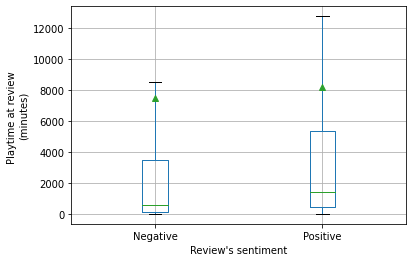

In [21]:
pd.DataFrame(data={
    'Negative': neg_playtime,
    'Positive': pos_playtime
}).boxplot(showfliers=False, showmeans=True)
plt.ylabel('Playtime at review \n(minutes)');
plt.xlabel("Review's sentiment");

### See the effect size

How can we be sure that there is a real difference between the two groups (the playtime of who liked a game and who not) and that we do not fall into the significance fallacy (statistical significance does not necessary mean reality significance)?<br>
The *Cohen's d* has been used specifically for that purpose.

In [22]:
def cohens_d(mean_diff, n1, n2, pos_std, neg_std):
    return mean_diff / (math.sqrt(((n1 - 1) * (pos_std ** 2) + (n2 - 1) * (neg_std ** 2)) / (n1 + n2 - 2)))

x1 = pos_playtime
x2 = neg_playtime
print("Cohen's d:", round(cohens_d(x1.mean() - x2.mean(), len(x1), len(x2), x1.std(), x2.std()),2))

Cohen's d: 0.03


The Cohen's d coefficient is really small (effect size is small), so there is a difference between the two groups (in fact there is a positive correlation), but the difference is so tiny that it can be not considered relevant in a real case scenario (but in a statistical context yes).

## Big Data analysis